In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect 

In [4]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Inspect database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Identify column names and types for measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Find the most recent date in the data set
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

Query Date:  2016-08-23


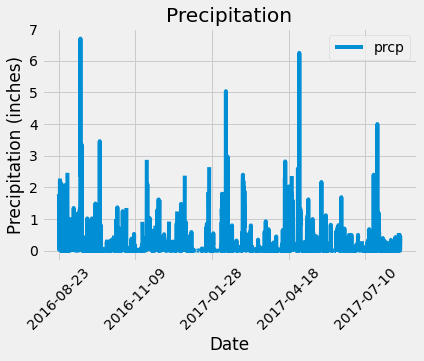

In [70]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Calculate the date one year from the last date in data set.
last_year = dt.date(2017,8, 23) - dt.timedelta(days=365)
print("Query Date: ", last_year)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
precipitation = session.query(*sel).\
    filter(Measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation, columns=['date', 'prcp'])

# Sort by date
df = df.sort_values("date")
df

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x="date", y="prcp")
plt.title("Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [49]:
session.query(Station.station).all()

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [79]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9)]

In [77]:
# List the stations and their measurement counts in descending order.
sel = [Measurement.station, func.count(Measurement.id)]
stations_activity = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
print(stations_activity)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [78]:
# Determine the most active station (i.e. what station has the most rows?)
most_active_station = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
print(most_active_station)

('USC00519281', 2772)


In [99]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

temperatures = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    group_by(Measurement.station).all()

# Display in dataframe 
temperature_data = pd.DataFrame(temperatures, columns=['Station', 'Min Temperature', 'Max Temperature', 'Average Temperature'])
temperature_data

,Station,Min Temperature,Max Temperature,Average Temperature
0,USC00519281,54.0,85.0,71.663781


In [105]:
# Query the last 12 months of temperature observation data for the most active station 
sel = [Measurement.date, Measurement.tobs]
temperature_last_year = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= last_year).all()

# Place into dataframe 
recent_temperatures = pd.DataFrame(temperature_last_year, columns=['Date', 'TOBS'])
recent_temperatures                         

,Date,TOBS
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


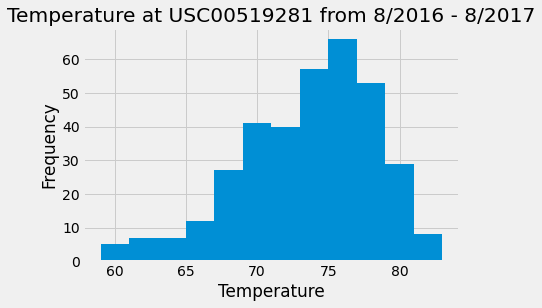

In [108]:
# Plot the results as a histogram
hist = recent_temperatures["TOBS"].hist(bins=12)
plt.title("Temperature at USC00519281 from 8/2016 - 8/2017")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.show()      

# Close session

In [109]:
# Close Session
session.close()